In [1]:
import requests
import json
import csv  # Import the csv module

In [11]:
import requests
import json
import csv
import concurrent.futures
import os # Import os to potentially read the key from environment variables

# output_filename = 'control_grade.csv'
# filename = 'control.txt'
# Consider using environment variables for sensitive keys
# key = os.environ.get("OPENROUTER_API_KEY", "YOUR_DEFAULT_KEY_HERE") # Example using environment variable

# If you prefer to keep it in the script for now, but be cautious about committing it
key = "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"


def get_grade(story: str, story_index: int):
    """Sends a story to the API for grading and returns the parsed grades."""
    try:
        response = requests.post(
            "https://openrouter.ai/api/v1/chat/completions",
            headers={
                "Authorization": f"Bearer {key}",
                "Content-Type": "application/json",
            },
            json={
                "model": "google/gemini-2.5-flash-preview",
                "messages": [
                    {"role": "user", "content": f"""In the following exercise, the student is given a task of writing a short story.
The student needs to come up with a coherent story that is graded on criteria mentioned below. The exercise tests the student’s language abilities,
creativity, and ability to follow directions.
{story}
Please provide your general assessment about the story written by the
student. Consider the following aspects:
1. Grammar: Is the completion grammatically correct?
2. Creativity: Does the completion show creativity and original thought?
3. Consistency: Is the completion consistent with the beginning of the story?
4. Plot: Does the plot of the completion make sense and is it coherent throughout?
Now, grade the student’s completion in terms of the following categories,
each on a scale from 1 to 10."""},
                ],
                "response_format": {
                    "type": "json_schema",
                    "json_schema": {
                        "name": "grade",
                        "strict": True,
                        "schema": {
                            "type": "object",
                            "properties": {
                                "Grammer": {
                                    "type": "number",
                                    "description": "Is the completion grammatically correct?",
                                },
                                "Creativity": {
                                    "type": "number",
                                    "description": "Does the completion show creativity and original thought?",
                                },
                                "Consistency": {
                                    "type": "number",
                                    "description": "Is the completion consistent with the beginning of the story?",
                                },
                                "Plot": {
                                    "type": "number",
                                    "description": "Does the plot of the completion make sense and is it coherent throughout?",
                                },
                            },
                            "required": ["Grammer", "Creativity", "Consistency", "Plot"],
                            "additionalProperties": False,
                        },
                    },
                },
            },
        )
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        data = response.json()
        # Assuming the structure of the response's content is a JSON string
        grade_string = data["choices"][0]["message"]["content"]
        grade_json = json.loads(grade_string)
        # Extract the grades
        grammar_grade = grade_json.get("Grammer")
        creativity_grade = grade_json.get("Creativity")
        consistency_grade = grade_json.get("Consistency")
        plot_grade = grade_json.get("Plot")
        print(f"Processed story {story_index}. Grades: Grammar={grammar_grade}, Creativity={creativity_grade}, Consistency={consistency_grade}, Plot={plot_grade}")
        return story_index, grammar_grade, creativity_grade, consistency_grade, plot_grade
    except requests.exceptions.RequestException as e:
        print(f"Error making API request for story {story_index}: {e}")
        return story_index, None, None, None, None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON response for story {story_index}: {e}. Received content: {grade_string}")
        return story_index, None, None, None, None
    except KeyError as e:
        print(f"Unexpected JSON structure in response for story {story_index}: {e}. Received data: {data}")
        return story_index, None, None, None, None
    except Exception as e:
        print(f"An unexpected error occurred for story {story_index}: {e}")
        return story_index, None, None, None, None

def parse_file_sections(filename, delimiter="---------------"):
    """Parses a text file into sections separated by a delimiter."""
    sections = []
    current_section = []
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            for line in file:
                if line.strip() == delimiter:
                    # Join the lines in the current section and add to the list
                    sections.append("".join(current_section).strip())
                    # Reset the current section for the next block
                    current_section = []
                else:
                    current_section.append(line)
            # After the loop, there might be text after the last delimiter
            if current_section:
                sections.append("".join(current_section).strip())
    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return None
    except Exception as e:
        print(f"An error occurred while parsing the file: {e}")
        return None
    return sections

if __name__ == "__main__":
    output_filename = 'three_part_grade.csv'
    filename = 'three_part.txt'

    stories = parse_file_sections(filename)
    grades_data = []
    # Add the header row
    grades_data.append(["Story Index", "Grammar", "Creativity", "Consistency", "Plot"])

    if stories is not None:
        # Use ThreadPoolExecutor for concurrent API calls
        # max_workers determines the number of concurrent threads
        # Adjust max_workers based on your system resources and the API's rate limits
        with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
            # Submit each story to the executor. map() submits and returns results
            # in the order they were submitted, which is important for matching
            # grades with story indices.
            results = executor.map(lambda item: get_grade(item[1], item[0]), enumerate(stories))

            # Process the results as they are completed
            for result in results:
                grades_data.append(list(result)) # Convert tuple result to list

        # Write the data to the CSV file
        if grades_data and len(grades_data) > 1: # Check if there's any data besides the header
            with open(output_filename, 'w', newline='', encoding='utf-8') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerows(grades_data)
            print(f"Grades saved to {output_filename}")
        elif len(grades_data) == 1:
            print("No grades were successfully processed to save (only header exists).")
        else:
            print("No stories were found to process.")
    else:
        print("Could not parse stories from the input file.")

Processed story 2. Grades: Grammar=2, Creativity=3, Consistency=2, Plot=2
Processed story 19. Grades: Grammar=3, Creativity=2, Consistency=2, Plot=2
Processed story 14. Grades: Grammar=2, Creativity=4, Consistency=3, Plot=2
Processed story 0. Grades: Grammar=3, Creativity=3, Consistency=2, Plot=2
Processed story 13. Grades: Grammar=2, Creativity=4, Consistency=3, Plot=2
Processed story 5. Grades: Grammar=2, Creativity=3, Consistency=2, Plot=1
Processed story 18. Grades: Grammar=1, Creativity=3, Consistency=2, Plot=1
Processed story 3. Grades: Grammar=5, Creativity=4, Consistency=4, Plot=3
Processed story 10. Grades: Grammar=4, Creativity=3, Consistency=2, Plot=2
Processed story 1. Grades: Grammar=5, Creativity=3, Consistency=2, Plot=2
Processed story 7. Grades: Grammar=2, Creativity=4, Consistency=2, Plot=2
Processed story 4. Grades: Grammar=3, Creativity=4, Consistency=3, Plot=3
Processed story 15. Grades: Grammar=2, Creativity=3, Consistency=2, Plot=1
Processed story 6. Grades: Gramm

In [12]:
import csv

def average_story_scores(filename):
    scores = {
        'Grammar': [],
        'Creativity': [],
        'Consistency': [],
        'Plot': []
    }

    try:
        with open(filename, 'r', newline='') as csvfile:
            reader = csv.DictReader(csvfile)

            # Check if the required columns exist
            required_headers = ['Grammar', 'Creativity', 'Consistency', 'Plot']
            if not all(header in reader.fieldnames for header in required_headers):
                print(f"Error: CSV file does not contain all required headers: {required_headers}")
                return {}

            for row in reader:
                try:
                    for category in required_headers:
                        # Cast to float for all scores
                        scores[category].append(float(row[category]))
                except (ValueError, KeyError) as e:
                    print(f"Warning: Skipping row due to data error: {row}, Error: {e}")
                    continue

        averaged_scores = {}
        for category, score_list in scores.items():
            if score_list:  # Avoid dividing by zero if no valid scores found
                averaged_scores[category] = sum(score_list) / len(score_list)
            else:
                averaged_scores[category] = 0.0  # Or indicate no data, depending on preference

        return averaged_scores

    except FileNotFoundError:
        print(f"Error: File not found at {filename}")
        return {}
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}


# Call the function to process the CSV
average_scores_result = average_story_scores("three_part_grade.csv")

if average_scores_result:
    print("Average scores:")
    sumed = 0
    for category, avg in average_scores_result.items():
        print(f"{category}: {avg:.2f}")
        sumed += avg
    print(f"average: {sumed/4}")

Average scores:
Grammar: 3.52
Creativity: 3.54
Consistency: 2.85
Plot: 2.40
average: 3.0771484375


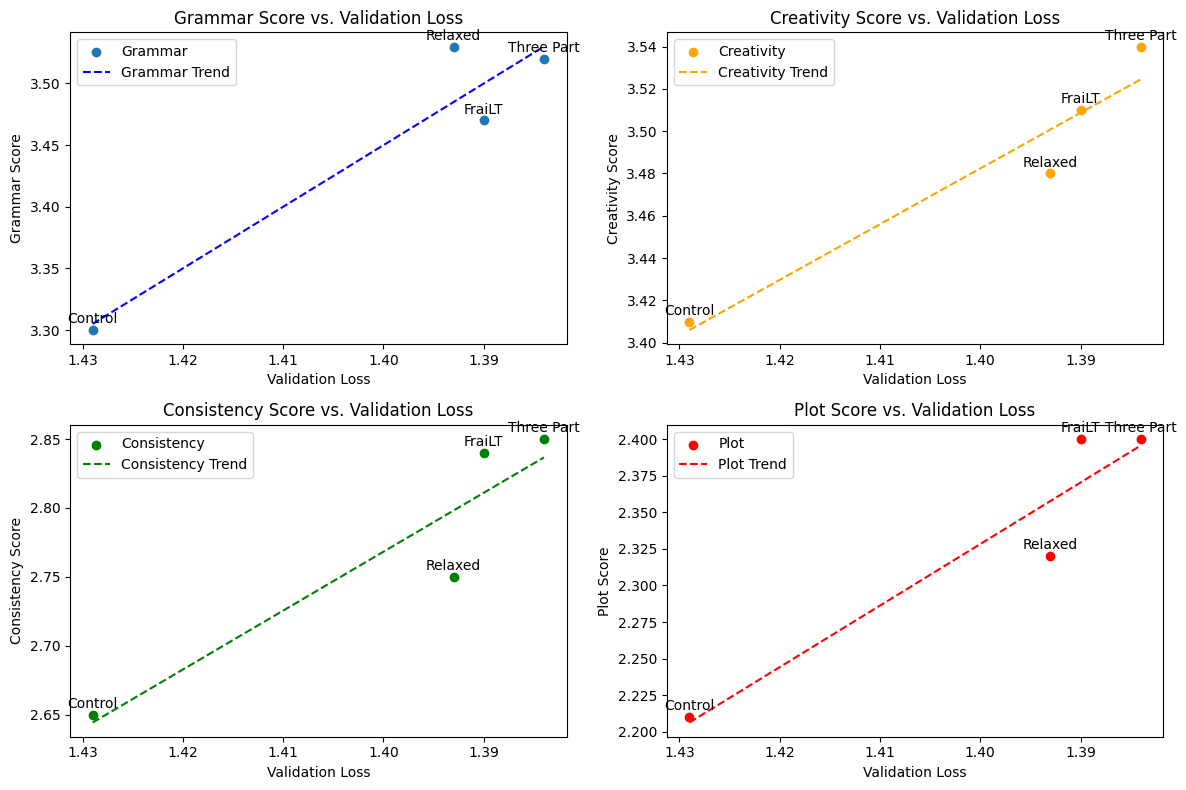

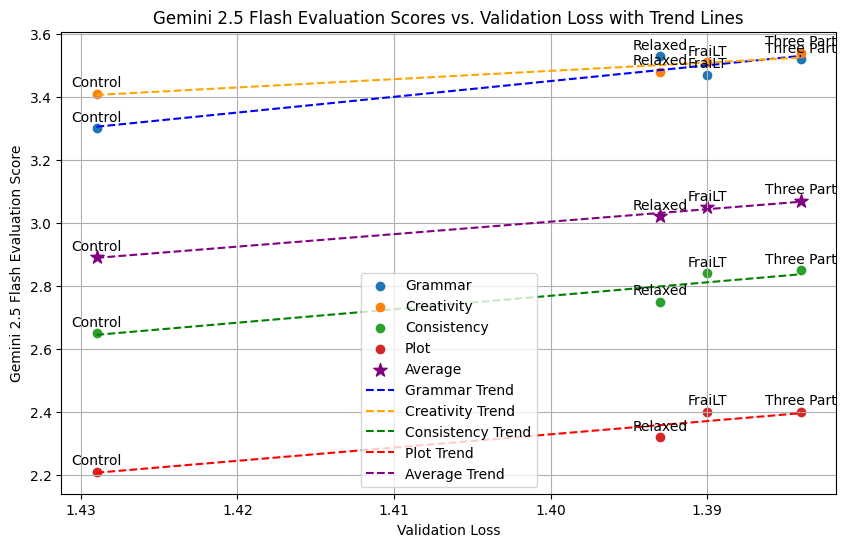

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Data from the tables
validation_loss = np.array([1.429, 1.393, 1.390, 1.384])
grammar = np.array([3.30, 3.53, 3.47, 3.52])
creativity = np.array([3.41, 3.48, 3.51, 3.54])
consistency = np.array([2.65, 2.75, 2.84, 2.85])
plot = np.array([2.21, 2.32, 2.40, 2.40])
average = np.array([2.89, 3.02, 3.05, 3.07])
model_names = ['Control', 'Relaxed', 'FraiLT', 'Three Part']

# Function to add a trend line (linear regression)
def add_trendline(x, y, label, color):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, intercept + slope * x, color=color, linestyle='--', label=f'{label} Trend')

# Create scatter plots with trend lines for each metric

plt.figure(figsize=(12, 8))

# Grammar vs. Validation Loss
plt.subplot(2, 2, 1)
plt.scatter(validation_loss, grammar, label='Grammar')
add_trendline(validation_loss, grammar, 'Grammar', 'blue')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (validation_loss[i], grammar[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel('Validation Loss')
plt.ylabel('Grammar Score')
plt.title('Grammar Score vs. Validation Loss')
plt.gca().invert_xaxis() # Invert x-axis since lower loss is better
plt.legend()

# Creativity vs. Validation Loss
plt.subplot(2, 2, 2)
plt.scatter(validation_loss, creativity, label='Creativity', color='orange')
add_trendline(validation_loss, creativity, 'Creativity', 'orange')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (validation_loss[i], creativity[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel('Validation Loss')
plt.ylabel('Creativity Score')
plt.title('Creativity Score vs. Validation Loss')
plt.gca().invert_xaxis()
plt.legend()

# Consistency vs. Validation Loss
plt.subplot(2, 2, 3)
plt.scatter(validation_loss, consistency, label='Consistency', color='green')
add_trendline(validation_loss, consistency, 'Consistency', 'green')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (validation_loss[i], consistency[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel('Validation Loss')
plt.ylabel('Consistency Score')
plt.title('Consistency Score vs. Validation Loss')
plt.gca().invert_xaxis()
plt.legend()

# Plot vs. Validation Loss
plt.subplot(2, 2, 4)
plt.scatter(validation_loss, plot, label='Plot', color='red')
add_trendline(validation_loss, plot, 'Plot', 'red')
for i, txt in enumerate(model_names):
    plt.annotate(txt, (validation_loss[i], plot[i]), textcoords="offset points", xytext=(0,5), ha='center')
plt.xlabel('Validation Loss')
plt.ylabel('Plot Score')
plt.title('Plot Score vs. Validation Loss')
plt.gca().invert_xaxis()
plt.legend()

plt.tight_layout()
plt.show()

# Create a single plot with all metrics and trend lines
plt.figure(figsize=(10, 6))
plt.scatter(validation_loss, grammar, label='Grammar')
plt.scatter(validation_loss, creativity, label='Creativity')
plt.scatter(validation_loss, consistency, label='Consistency')
plt.scatter(validation_loss, plot, label='Plot')
plt.scatter(validation_loss, average, label='Average', marker='*', s=100, color='purple') # Highlight average

add_trendline(validation_loss, grammar, 'Grammar', 'blue')
add_trendline(validation_loss, creativity, 'Creativity', 'orange')
add_trendline(validation_loss, consistency, 'Consistency', 'green')
add_trendline(validation_loss, plot, 'Plot', 'red')
add_trendline(validation_loss, average, 'Average', 'purple') # Add trendline for average

for i, txt in enumerate(model_names):
    plt.annotate(txt, (validation_loss[i], grammar[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(txt, (validation_loss[i], creativity[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(txt, (validation_loss[i], consistency[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(txt, (validation_loss[i], plot[i]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.annotate(txt, (validation_loss[i], average[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Validation Loss')
plt.ylabel('Gemini 2.5 Flash Evaluation Score')
plt.title('Gemini 2.5 Flash Evaluation Scores vs. Validation Loss with Trend Lines')
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis() # Invert x-axis since lower loss is better
plt.show()